In [5]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from astropy.constants import G, c, M_sun, hbar

import astropy.units as u
from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

In [22]:
hc = 197.327 # MeV fm

B_1 = 145 ** 4 # Mev^4 

B_2 = 200 ** 4 # MeV^4

n0 = 0.16 # fm^-3

n0_mev3 = 0.16 * (hc**3) # Convert 0.16 fm^-3 to MeV^3 
# Plank's mass

m_planck = np.sqrt((hbar * c) / G) # kg

M_p = (m_planck * c**2).to(u.MeV)

print(f"Planck Mass: {M_p:.4e}")


Planck Mass: 1.2209e+22 MeV


Adimensional 

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$

# Compute numerical values for the EoS

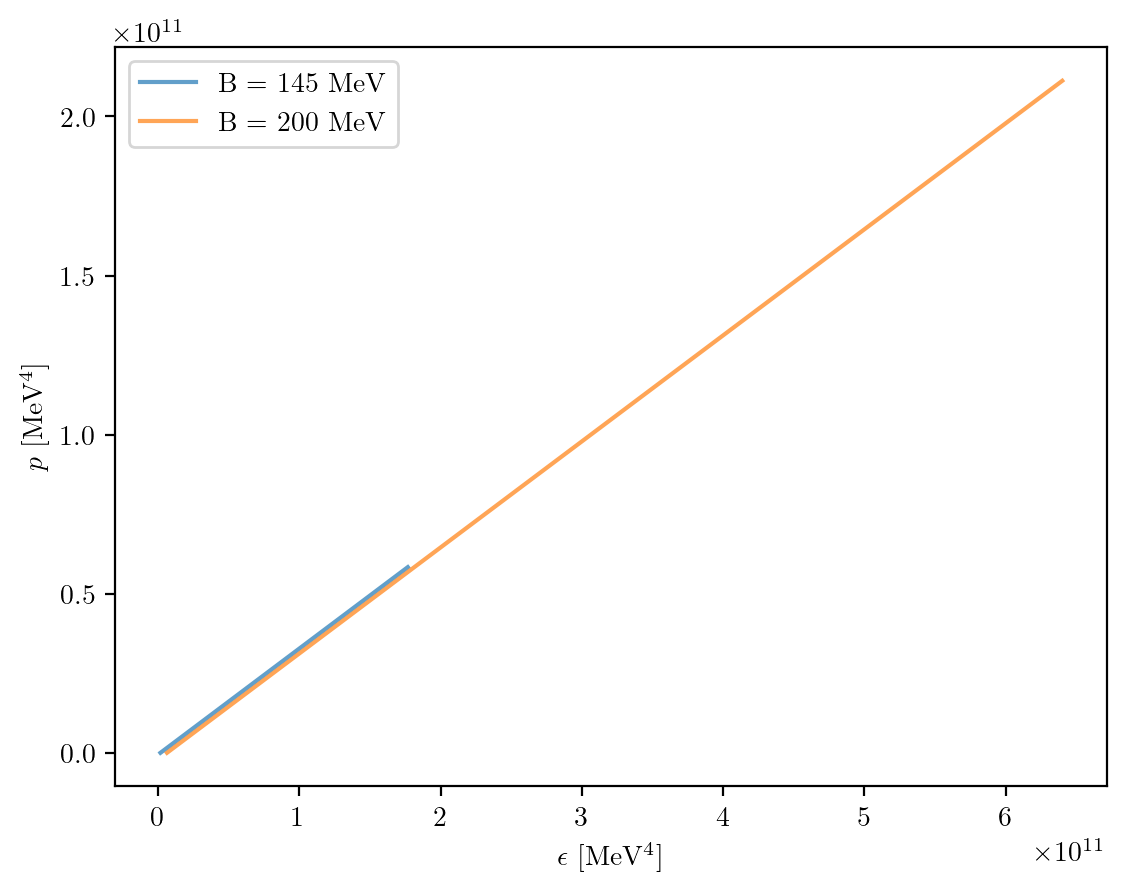

In [53]:
list_e_1 = np.linspace(1+1e-5, 100, 1000) * 4 * B_1
list_e_2 = np.linspace(1+1e-5, 100, 1000) * 4 * B_2

p_1 = 1/3*(list_e_1 - 4*B_1)
p_2 = 1/3*(list_e_2 - 4*B_2)

plt.plot(list_e_1, p_1, label='B = 145 MeV', alpha=0.7)
plt.plot(list_e_2, p_2, label='B = 200 MeV', alpha=0.7)
    
plt.xlabel(r'$\epsilon$ [MeV$^4$]')
plt.ylabel(r'$p$ [MeV$^4$]')
plt.legend()
plt.show()

The EoS is working

TOV:

$$
\frac{dp}{dr} = - \frac{M \epsilon}{r^2} \left(1+\frac{p}{\epsilon}\right) \left(1+ \frac{4\pi r^3 p}{M}\right)\left(1-\frac{2M}{r}\right)^{-1}
$$

$$
\frac{dM}{dr} = 4 \pi r^2 \epsilon
$$

Already wihout dimensions

In [54]:
list_p_1_adim = p_1 / (4 * B_1)
list_e_1_adim = list_e_1 / (4 * B_1)

list_p_2_adim = p_2 / (4 * B_2)
list_e_2_adim = list_e_2 / (4 * B_2)


In [55]:
list_p_1_adim

array([3.33333333e-06, 3.30363630e-02, 6.60693927e-02, 9.91024224e-02,
       1.32135452e-01, 1.65168482e-01, 1.98201512e-01, 2.31234541e-01,
       2.64267571e-01, 2.97300601e-01, 3.30333630e-01, 3.63366660e-01,
       3.96399690e-01, 4.29432719e-01, 4.62465749e-01, 4.95498779e-01,
       5.28531808e-01, 5.61564838e-01, 5.94597868e-01, 6.27630898e-01,
       6.60663927e-01, 6.93696957e-01, 7.26729987e-01, 7.59763016e-01,
       7.92796046e-01, 8.25829076e-01, 8.58862105e-01, 8.91895135e-01,
       9.24928165e-01, 9.57961195e-01, 9.90994224e-01, 1.02402725e+00,
       1.05706028e+00, 1.09009331e+00, 1.12312634e+00, 1.15615937e+00,
       1.18919240e+00, 1.22222543e+00, 1.25525846e+00, 1.28829149e+00,
       1.32132452e+00, 1.35435755e+00, 1.38739058e+00, 1.42042361e+00,
       1.45345664e+00, 1.48648967e+00, 1.51952270e+00, 1.55255573e+00,
       1.58558876e+00, 1.61862179e+00, 1.65165482e+00, 1.68468785e+00,
       1.71772088e+00, 1.75075391e+00, 1.78378694e+00, 1.81681997e+00,
      

In [ ]:

def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_1_adim, list_e_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_1), 'MeV^4')

    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_1 = []
list_M_1 = []





for i in range(len(list_e_1_adim)):

    e, p = list_e_1_adim[i], list_p_1_adim[i]

    r0 = 1e-5

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_1.append(R_surface)
    list_M_1.append(M_surface)




Now for the second constant

In [52]:

def solve_TOV(central_energy, x0):
    def ode_TOV_2(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_2_adim, list_e_2_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_2,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_2), 'MeV/fm^3')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_2 = []
list_M_2 = []


#list_p_adim_2 = np.array(list_p_2)/(4 * B_2)
#list_e_adim_2 = np.array(list_e_2)/(4 * B_2)



for i in range(len(list_e_2)):
    e, p = list_e_2[i], list_p_2[i]


    r0 = 1e-5                   

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_2.append(R_surface)
    list_M_2.append(M_surface)


No surface event for central energy = 6400064000.0
No surface event for central energy = 12800063353.535353
No surface event for central energy = 19200062707.07071
No surface event for central energy = 25600062060.606056
No surface event for central energy = 32000061414.141415
No surface event for central energy = 38400060767.676765
No surface event for central energy = 44800060121.21212
No surface event for central energy = 51200059474.74747
No surface event for central energy = 57600058828.28283
No surface event for central energy = 64000058181.81818
No surface event for central energy = 70400057535.35353
No surface event for central energy = 76800056888.88889
No surface event for central energy = 83200056242.42424
No surface event for central energy = 89600055595.9596
No surface event for central energy = 96000054949.49493
No surface event for central energy = 102400054303.0303
No surface event for central energy = 108800053656.56566
No surface event for central energy = 11520005301

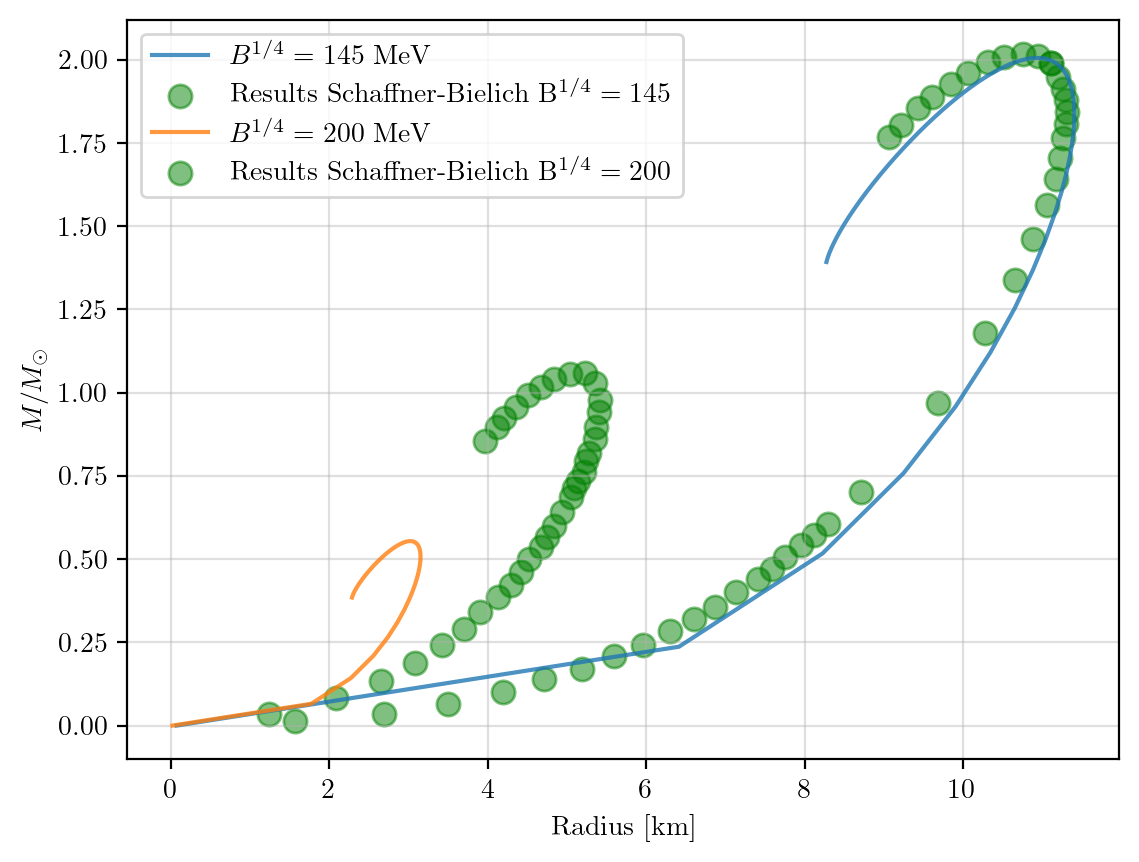

In [60]:
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

# --- Convert dimensionless R', M' ---
Radius_1 = np.array(list_R_1)
Mass_1 = np.array(list_M_1)


Rkm_1 = Radius_1 * M_p/ (2 * np.sqrt(B_1)) * hc * 1e-18 #km
Mass_mev_1 = Mass_1 * M_p**3 / (2 * np.sqrt(B_1)) #MeV


Mass_sol_1 = (Mass_mev_1 * mev_to_kg) / msun_kg

plt.plot(Rkm_1, Mass_sol_1, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel145.csv')
data= data[:-2]
data = data.drop(32)
data = data.drop(33)
plt.scatter(data['x'], data[' y'], label='Results  Schaffner-Bielich B$^{1/4}=145$', s=70, alpha=0.5,color='green')


list_R_2 = (145/200)**2 * Radius_1
list_M_2 = (145/200)**2 * Mass_1


# --- Convert B to geometrized units ---

# --- Convert dimensionless R', M' ---

Radius_2 = np.array(list_R_2)
Mass_2 = np.array(list_M_2)

R_km_2 = Radius_2 / (2 * np.sqrt(B_geo_2)) * 1e-3
M_meters_2 = Mass_2 / (2 * np.sqrt(B_geo_2))
M_solar_2 = (M_meters_2 * c.value**2 / G.value) / M_sun.value
plt.plot(R_km_2, M_solar_2, label=r'$B^{1/4}=200\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel200.csv')

plt.scatter(data['x'], data[' y'], label='Results  Schaffner-Bielich B$^{1/4}=200$', s=70, alpha=0.5,color='green')

# --- Plot ---

plt.xlabel("Radius [km]")
plt.ylabel(r"$M/M_\odot$")
plt.grid()
plt.legend()
plt.show()


# Compare with old code

###  '1_MIT_Bag_Model.ipynb' but seeting $m_q = 0$ 

In [78]:
# Adimensionalization constants
# e_0 for mev/fm^3

#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density
R_0 = (G * M_sun / c**2).to(u.km).value

n0  = n_0.value  # nuclear saturation density in fm^-3

hc = 197.327  # units 
B_label_max = 205
B_label_min = 145
B = B_label_min ** 4 / hc**3 # in MeV/fm^3


N_c_quarks = 3
N_c_lep = 1

m_s = 0  # strange quark mass
m_u = 0
m_d = 0
m_e = 0

In [79]:

def number_density_massless(mu):
    # Per u, d (quarks): n = kF^3/pi^2, mu = kF
    if mu < 0: return 0
    return (mu / hc)**3 / np.pi**2


def number_density_electron(mu):
    # Electrons: n = kF^3/(3*pi^2), mu = kF
    if mu < 0: return 0 
    return (mu / hc)**3 / (3 * np.pi**2)

def pressure_f_massless(N_c, mu_q):
    factor  = N_c * mu_q**4 / (24 * np.pi**2 * hc**3)
    return factor  # MeV/fm^3

def energy_f_massless(N_c, mu_q):
    factor  = N_c * mu_q**4 / (8 * np.pi**2 * hc**3)
    return factor # MeV/fm^3



# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massless(mu_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]


Number of points in EOS with positive pressure: 998
Failed points (negative pressure): 2
Number of points in EOS with positive pressure: 999
Failed points (negative pressure): 1


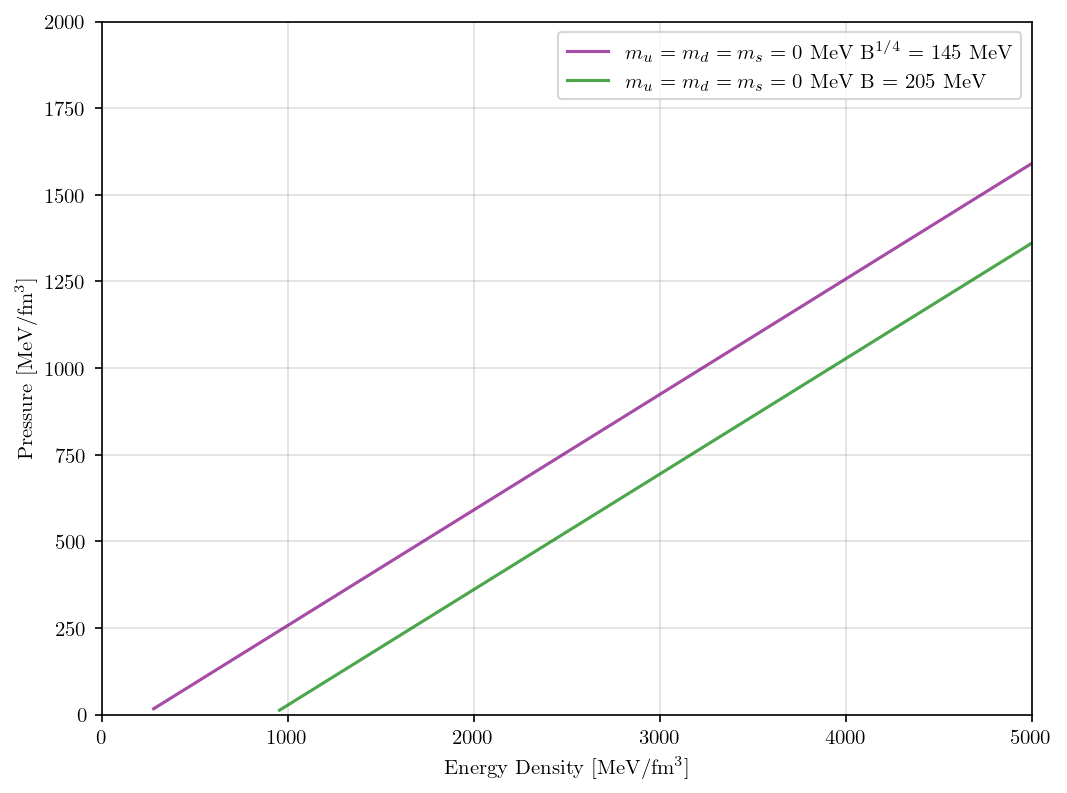

In [80]:
N_c_quarks = 3
N_c_lep = 1
B = 145 ** 4 / hc**3 # in MeV/fm^3

#----Range------

list_nb = np.linspace(0.1, 1000, 1000) * n0


list_failed_nb = []
list_e_min = []
list_p_min = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb:

    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol  
    guess = [mu_u, mu_e]     
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massless(mu_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f_massless(6, mu_u) + pressure_f_massless(6, mu_d) +
                    pressure_f_massless(6, mu_s) + pressure_f_massless(2, mu_e)) - B

    if pressure_total < 0:

        list_failed_nb.append(nB)
        continue


    energy_total =  (energy_f_massless(6, mu_u) + energy_f_massless(6, mu_d) +
                    energy_f_massless(6, mu_s) + energy_f_massless(2, mu_e)) + B

    z_s = m_s / mu_s 

    e = 3 * pressure_total + 4 * B 
    check_e = energy_total - e
    
    if abs(check_e) > 1e-6:
        print(f"Warning: energy density check failed: {check_e:.3e} MeV/fm^3")
        print('for nB=', nB)

    list_e_min.append(e)
    list_p_min.append(pressure_total)



list_nb_min_corrected= list_nb[len(list_failed_nb):]
print("Number of points in EOS with positive pressure:", len(list_nb_min_corrected))
print("Failed points (negative pressure):", len(list_failed_nb))

plt.figure(figsize=(8,6), dpi=150)
plt.plot(list_e_min, list_p_min, 
        label='$m_u = m_d = m_s = 0 $ MeV B$^{1/4}$ = 145 MeV', color='purple', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.grid()



#--------------------
# Maximum B
B = B_label_max ** 4 / hc**3 # in MeV/fm^3
list_nb = np.linspace(0.1, 5000, 1000) * n0

list_failed_n_max = []
list_e_max = []
list_p_max = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb:

    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol 
    guess = [mu_u, mu_e]   
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massless(mu_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f_massless(6, mu_u) + pressure_f_massless(6, mu_d) +
                    pressure_f_massless(6, mu_s) + pressure_f_massless(2, mu_e)) - B

    if pressure_total < 0:
        list_failed_n_max.append(nB)
        continue


    energy_total =  (energy_f_massless(6, mu_u) + energy_f_massless(6, mu_d) +
                    energy_f_massless(6, mu_s) + energy_f_massless(2, mu_e)) + B

    z_s = m_s / mu_s 

    e = 3 * pressure_total + 4 * B 
    check_e = energy_total - e
    
    if abs(check_e) > 1e-6:
        print(f"Warning: energy density check failed: {check_e:.3e} MeV/fm^3")
        print('for nB=', nB)

    list_e_max.append(energy_total)
    list_p_max.append(pressure_total)



list_nb_max_corrected = list_nb[len(list_failed_n_max):]
print("Number of points in EOS with positive pressure:", len(list_nb_max_corrected))
print("Failed points (negative pressure):", len(list_failed_n_max))

plt.plot(list_e_max, list_p_max, 
        label=f'$m_u = m_d = m_s = 0 $ MeV B = {B_label_max} MeV', color='green', alpha=0.7)

plt.legend()
plt.xlim(0, 5000)
plt.ylim(0, 2000)
plt.show()


In [81]:
print(len(list_nb_min_corrected), len(list_nb_max_corrected))
print(len(list_e_min), len(list_e_max))

998 999
998 999


In [57]:
list_p_min_adim = np.array(list_p_min)/e_0.value
list_e_min_adim = np.array(list_e_min)/e_0.value

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def solve_TOV(central_energy, x0):
    def ode_TOV(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_min_adim, list_e_min_adim)

            term1 = R_0 * e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + alpha * r**3 * p / M
            term4 = 1 - 2 * R_0 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr = alpha * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R = []
list_M = []

list_p_min_adim = np.array(list_p_min)/e_0.value
list_e_min_adim = np.array(list_e_min)/e_0.value

for i in range(len(list_nb_min_corrected)):
    e, p = list_e_min_adim[i], list_p_min_adim[i]

    central_energy = e / e_0.value
    central_pressure = p / e_0.value

    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass] 

    R_surface, M_surface = solve_TOV(central_energy, x0)


    list_R.append(R_surface)
    list_M.append(M_surface)




In [82]:
list_p_max_adim = np.array(list_p_max)/e_0.value
list_e_max_adim = np.array(list_e_max)/e_0.value

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def solve_TOV(central_energy, x0):
    def ode_TOV(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_max_adim, list_e_max_adim)

            term1 = R_0 * e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + alpha * r**3 * p / M
            term4 = 1 - 2 * R_0 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr = alpha * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * e_0, 'MeV/fm^3')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_max = []
list_M_max = []

for i in range(len(list_nb_max_corrected)):
    e, p = list_e_max_adim[i], list_p_max_adim[i]

    central_energy = e / e_0.value
    central_pressure = p / e_0.value

    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass] 

    R_surface, M_surface = solve_TOV(central_energy, x0)


    list_R_max.append(R_surface)
    list_M_max.append(M_surface)




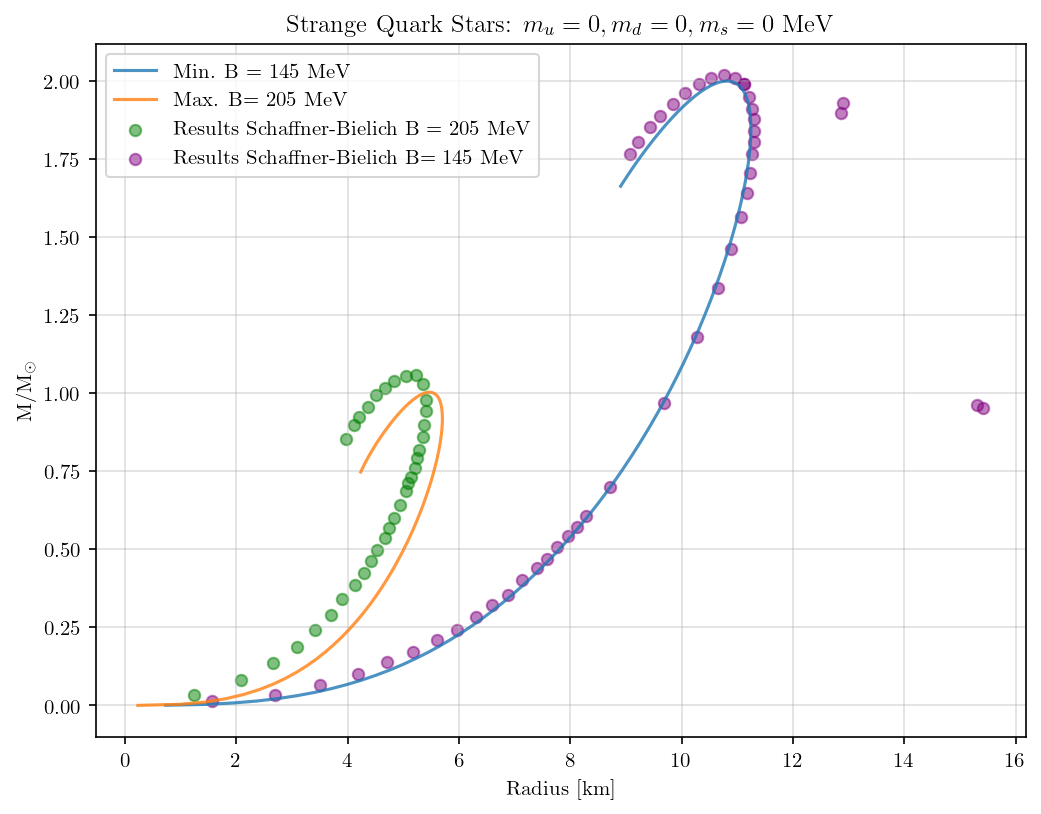

Maximum mass for min B: 2.0000402772947656 Solar masses
Maximum mass for max B: 1.0032483219361497 Solar masses


In [83]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(list_R, list_M, label=f'Min. B = {B_label_min} MeV',alpha=0.8)
#plt.plot(R_km_1, M_solar_1, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)


plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title(f"Strange Quark Stars: $m_u={m_u}, m_d={m_d}, m_s={m_s}$ MeV")

plt.plot(list_R_max, list_M_max, label=f'Max. B= {B_label_max} MeV',alpha=0.8)
#plt.plot(R_km_2, M_solar_2, label=r'$B^{1/4}=200\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel200.csv')
plt.scatter(data['x'], data[' y'], label=f'Results  Schaffner-Bielich B = {B_label_max} MeV', s=30, alpha=0.5,color='green')

data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel145.csv')
plt.scatter(data['x'], data[' y'], label=f'Results  Schaffner-Bielich B= {B_label_min} MeV', s=30, alpha=0.5,color='purple')


plt.grid()
plt.legend()

plt.show()

print("Maximum mass for min B:", max(list_M), "Solar masses")
print("Maximum mass for max B:", max(list_M_max), "Solar masses")

In [ ]:
# Adimensionalization constants
# e_0 for mev/fm^3

#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density
R_0 = (G * M_sun / c**2).to(u.km).value

n0  = n_0.value  # nuclear saturation density in fm^-3

hc = 197.327  # units 
B_label_max = 200
B_label_min = 145
B = B_label_min ** 4 / hc**3 # in MeV/fm^3


N_c_quarks = 3
N_c_lep = 1

m_s = 93.0  # strange quark mass
m_u = 4.0
m_d = 4.0
m_e = 0.0

def number_density_massless(mu):
    # Per u, d (quarks): n = kF^3/pi^2, mu = kF
    if mu < 0: return 0
    return (mu / hc)**3 / np.pi**2

def number_density_massive(mu, mass):
    # Per s (quark) n = kF^3/pi^2, mu = kF^2 + m^2
    if mu < mass:
        return 0.0
    kF = np.sqrt(mu**2 - mass**2)
    return (kF / hc)**3 / np.pi**2

def number_density_electron(mu):
    # Electrons: n = kF^3/(3*pi^2), mu = kF
    if mu < 0: return 0 
    return (mu / hc)**3 / (3 * np.pi**2)

def pressure_f(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (24 * np.pi**2 * hc**3)
    z_q = m_q / mu_q
    if z_q >= 1: return 0
    if z_q == 0:
        return factor
    term1 = (1-z_q**2)**(1/2)* (1-5/2 * z_q**2)
    term2 = 3/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
    return factor * (term1 + term2) # MeV/fm^3

def energy_f(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (8 * np.pi**2 * hc**3)
    z_q = m_q / mu_q
    if z_q >= 1: return 0
    if z_q ==0:
        return factor
    term1 = (1-z_q**2)**(1/2)* (1-1/2 * z_q**2)
    term2 = -1/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
    return factor * (term1 + term2) # MeV/fm^3


# --- SISTEMA D'EQUACIONS A RESOLTRE ---


def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]



In [37]:
B = B_label_min ** 4 / hc**3 # in MeV/fm^3

N_c_quarks = 3
N_c_lep = 1


#----Range------

list_nb = np.linspace(0.1, 1000, 1000) * n0


list_failed_nb = []
list_e_min = []
list_p_min = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb:

    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol  
    guess = [mu_u, mu_e]     
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")

    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B


    if pressure_total < 0:

        list_failed_nb.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B


    list_e_min.append(energy_total)
    list_p_min.append(pressure_total)



list_nb_min_corrected= list_nb[len(list_failed_nb):]
print("Number of points in EOS with positive pressure:", len(list_nb_min_corrected))
print("Failed points (negative pressure):", len(list_failed_nb))


Number of points in EOS with positive pressure: 998
Failed points (negative pressure): 2


Number of points in EOS with positive pressure: 4995
Failed points (negative pressure): 5


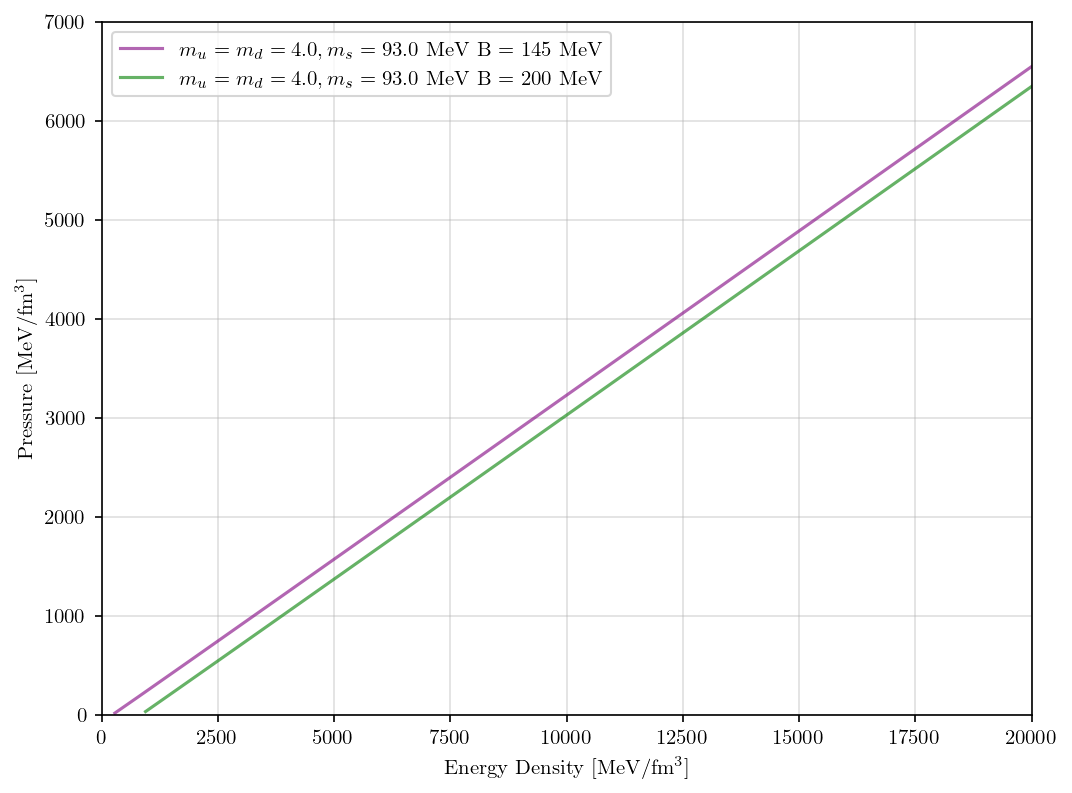

998 4995
998 4995


In [43]:

plt.figure(figsize=(8,6), dpi=150)
plt.plot(list_e_min, list_p_min, 
        label=f'$m_u = m_d = {m_u}, m_s = {m_s} $ MeV B = {B_label_min} MeV', color='purple', alpha=0.6)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.grid()


#--------------------
# Maximum B
B = B_label_max ** 4 / hc**3 # in MeV/fm^3

list_nb = np.linspace(0.1, 5000, 5000) * n0

list_failed_n_max = []
list_e_max = []
list_p_max = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb:

    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol  
    guess = [mu_u, mu_e]     
    mu_d = mu_u + mu_e
    mu_s = mu_d
        
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")

    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - B


    if pressure_total < 0:
        list_failed_n_max.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + B

    list_e_max.append(energy_total)
    list_p_max.append(pressure_total)
    

list_nb_max_corrected = list_nb[len(list_failed_n_max):]
print("Number of points in EOS with positive pressure:", len(list_nb_max_corrected))
print("Failed points (negative pressure):", len(list_failed_n_max))

plt.plot(list_e_max, list_p_max, 
        label=f'$m_u = m_d = {m_u}, m_s = {m_s} $ MeV B = {B_label_max} MeV', color='green', alpha=0.6)

plt.legend()
plt.xlim(0, 2e4)
plt.ylim(0, 7e3)
plt.show()

print(len(list_nb_min_corrected), len(list_nb_max_corrected))
print(len(list_e_min), len(list_e_max))

In [44]:

list_p_min_adim = np.array(list_p_min)/e_0.value
list_e_min_adim = np.array(list_e_min)/e_0.value

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def solve_TOV(central_energy, x0):
    def ode_TOV(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_min_adim, list_e_min_adim)

            term1 = R_0 * e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + alpha * r**3 * p / M
            term4 = 1 - 2 * R_0 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr = alpha * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R = []
list_M = []

list_p_min_adim = np.array(list_p_min)/e_0.value
list_e_min_adim = np.array(list_e_min)/e_0.value

for i in range(len(list_nb_min_corrected)):
    e, p = list_e_min_adim[i], list_p_min_adim[i]

    central_energy = e / e_0.value
    central_pressure = p / e_0.value

    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass] 

    R_surface, M_surface = solve_TOV(central_energy, x0)


    list_R.append(R_surface)
    list_M.append(M_surface)



In [45]:
list_p_max_adim = np.array(list_p_max)/e_0.value
list_e_max_adim = np.array(list_e_max)/e_0.value

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def solve_TOV(central_energy, x0):
    def ode_TOV(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_max_adim, list_e_max_adim)

            term1 = R_0 * e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + alpha * r**3 * p / M
            term4 = 1 - 2 * R_0 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr = alpha * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * e_0, 'MeV/fm^3')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_max = []
list_M_max = []

for i in range(len(list_nb_max_corrected)):
    e, p = list_e_max_adim[i], list_p_max_adim[i]

    central_energy = e / e_0.value
    central_pressure = p / e_0.value

    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass] 

    R_surface, M_surface = solve_TOV(central_energy, x0)


    list_R_max.append(R_surface)
    list_M_max.append(M_surface)



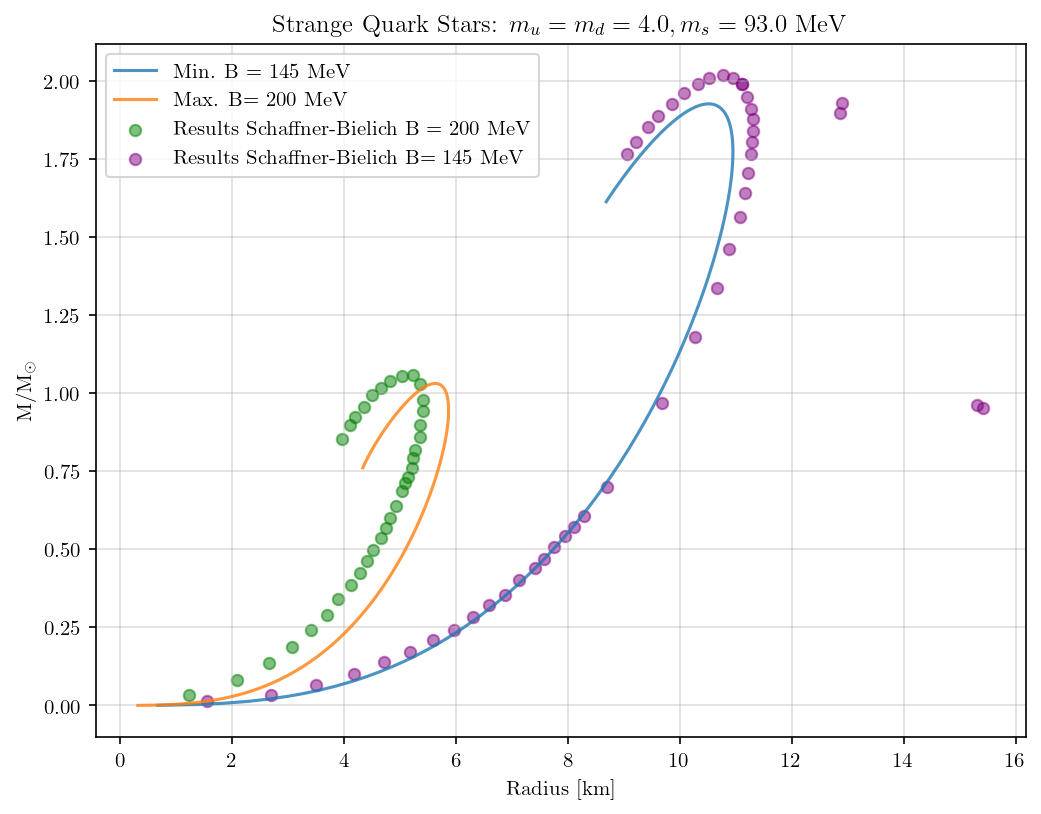

Maximum mass for min B: 1.9271049813367247 Solar masses
Maximum mass for max B: 1.0313378026090083 Solar masses


In [47]:

plt.figure(figsize=(8,6), dpi=150)

plt.plot(list_R, list_M, label=f'Min. B = 145 MeV',alpha=0.8)
#plt.plot(R_km_1, M_solar_1, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)


plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title(f"Strange Quark Stars: $m_u=m_d={m_u}, m_s = {m_s}$ MeV")

plt.plot(list_R_max, list_M_max, label=f'Max. B= {B_label_max} MeV',alpha=0.8)
#plt.plot(R_km_2, M_solar_2, label=r'$B^{1/4}=200\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel200.csv')
plt.scatter(data['x'], data[' y'], label=f'Results  Schaffner-Bielich B = 200 MeV', s=30, alpha=0.5,color='green')

data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel145.csv')
plt.scatter(data['x'], data[' y'], label=f'Results  Schaffner-Bielich B= {B_label_min} MeV', s=30, alpha=0.5,color='purple')


plt.grid()
plt.legend()

plt.show()

print("Maximum mass for min B:", max(list_M), "Solar masses")
print("Maximum mass for max B:", max(list_M_max), "Solar masses")

Number of points in EOS with positive pressure: 999
Failed points (negative pressure): 1
Number of points in EOS with positive pressure: 999
Failed points (negative pressure): 1
Number of points in EOS with positive pressure: 999
Failed points (negative pressure): 1
Number of points in EOS with positive pressure: 999
Failed points (negative pressure): 1


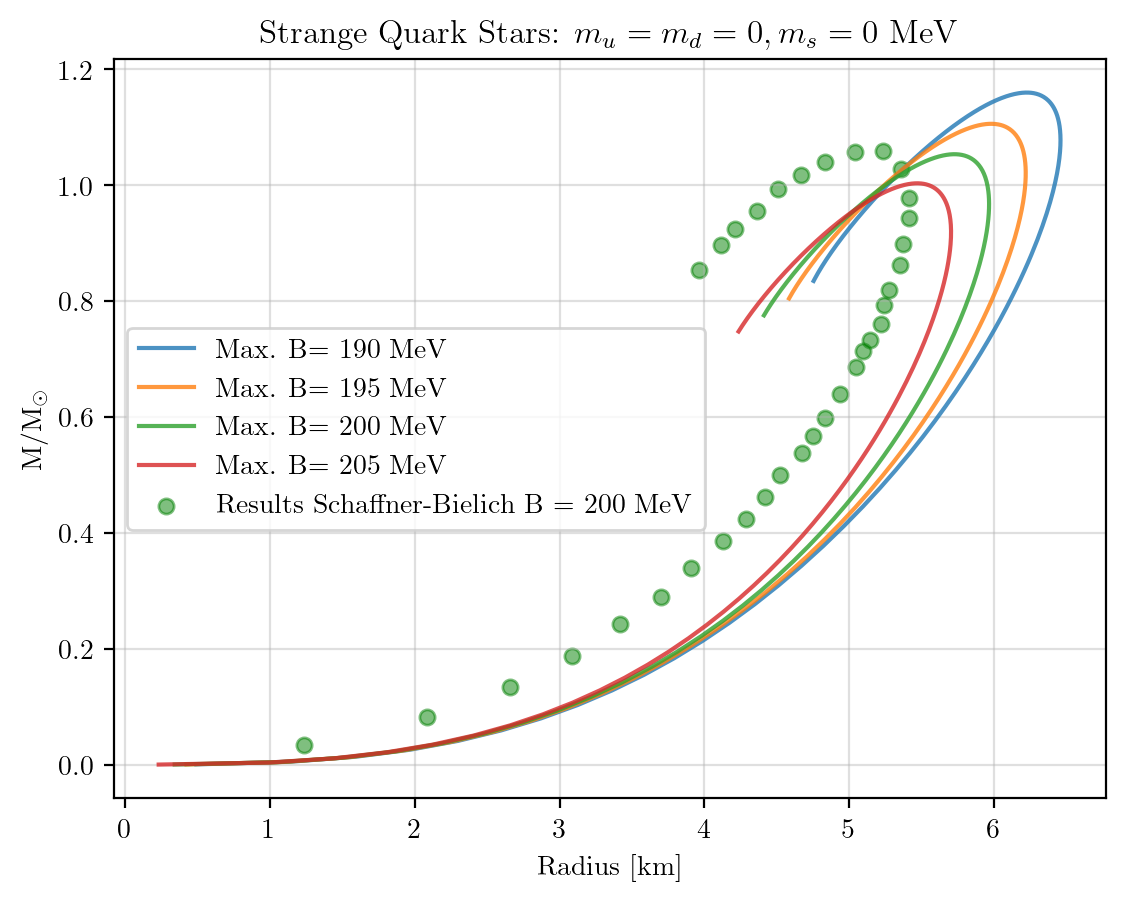

In [ ]:
# Adimensionalization constants
# e_0 for mev/fm^3

#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density
R_0 = (G * M_sun / c**2).to(u.km).value

n0  = n_0.value  # nuclear saturation density in fm^-3

hc = 197.327  # units 

N_c_quarks = 3
N_c_lep = 1

m_s = 0  # strange quark mass
m_u = 0
m_d = 0
m_e = 0



# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massless(mu_u)
    nd = number_density_massless(mu_d)
    ns = number_density_massless(mu_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]

list_nb = np.linspace(0.1, 5000, 1000) * n0
different_Bag_constants = [190, 195, 200, 205]

for B_value in different_Bag_constants:
    B = B_value ** 4 / hc**3 # in MeV/fm^3



    list_failed_n_max = []
    list_e_max = []
    list_p_max = []
    guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

    for nB in list_nb:

        sol = fsolve(equationsNB, guess, args=(nB))
        mu_u, mu_e = sol 
        guess = [mu_u, mu_e]   
        mu_d = mu_u + mu_e
        mu_s = mu_d
            
        nu = number_density_massless(mu_u)
        nd = number_density_massless(mu_d)
        ns = number_density_massless(mu_s)
        ne = number_density_electron(mu_e)

        check_nb = (1/3)*(nu + nd + ns) - nB
        check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

        if abs(check_nb) > 1e-6:
            print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

        if abs(check_charge) > 1e-6:
            print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


        pressure_total = (pressure_f_massless(6, mu_u) + pressure_f_massless(6, mu_d) +
                        pressure_f_massless(6, mu_s) + pressure_f_massless(2, mu_e)) - B

        if pressure_total < 0:
            list_failed_n_max.append(nB)
            continue


        energy_total =  (energy_f_massless(6, mu_u) + energy_f_massless(6, mu_d) +
                        energy_f_massless(6, mu_s) + energy_f_massless(2, mu_e)) + B


        list_e_max.append(energy_total)
        list_p_max.append(pressure_total)



    list_nb_max_corrected = list_nb[len(list_failed_n_max):]
    print("Number of points in EOS with positive pressure:", len(list_nb_max_corrected))
    print("Failed points (negative pressure):", len(list_failed_n_max))


    list_p_max_adim = np.array(list_p_max)/e_0.value
    list_e_max_adim = np.array(list_e_max)/e_0.value

    alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

    def solve_TOV(central_energy, x0):
        def ode_TOV(r, x):
                p, M = x
                if p < 0:
                    return [0, 0]

                e = np.interp(p, list_p_max_adim, list_e_max_adim)

                term1 = R_0 * e * M / r**2
                term2 = 1 + p / e
                if M == 0:
                    term3 = 1.0
                else:
                    term3 = 1.0 + alpha * r**3 * p / M
                term4 = 1 - 2 * R_0 * M / r

                if term4 <= 0:
                    return [0, 0]

                dpdr = - term1 * term2 * term3 / term4
                dMdr = alpha * r**2 * e

                return [dpdr, dMdr]

        
        # ----------------------------------------------------
        # Solve ODE
        # ----------------------------------------------------

        # This solver automatically adjusts step size to control error
        sol = solve_ivp(
            ode_TOV,
            (r0, 100),     # integrate up to r=100 (large enough)
            x0,
            events=surface_event,
            max_step=0.1,
            rtol=1e-8, atol=1e-10 #tolerance error
        )

        if len(sol.t_events[0]) == 0:
            print(f"No surface event for central energy = {central_energy}")
            return np.nan, np.nan
        
        M_surface = sol.y_events[0][0][1]
        P_surface = sol.y_events[0][0][0]
        R_surface = sol.t_events[0][0]

        if P_surface > 1e-5 :
            print("Final pressure is far from 0:", P_surface * e_0, 'MeV/fm^3')
        
        return R_surface, M_surface


    # ----------------------------------------------------
    # Event: stop integration when pressure goes to zero
    # ----------------------------------------------------
    def surface_event(r, x):
        return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                        # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
    surface_event.terminal = True # stop the integration
    surface_event.direction = -1 # only detect zero-crossing from positive to negative


    list_R_max = []
    list_M_max = []

    for i in range(len(list_nb_max_corrected)):
        e, p = list_e_max_adim[i], list_p_max_adim[i]

        central_energy = e / e_0.value
        central_pressure = p / e_0.value

        r0 = 0.1            
        central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
        central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value 
        x0 = [central_pressure, central_mass] 

        R_surface, M_surface = solve_TOV(central_energy, x0)


        list_R_max.append(R_surface)
        list_M_max.append(M_surface)




    plt.plot(list_R_max, list_M_max, label=f'Max. B= {B_value} MeV',alpha=0.8)


data = pd.read_csv('/Users/julia/Desktop/Master HEP Astro & Cosmo/Master-Git/Data/BagModel200.csv')
plt.scatter(data['x'], data[' y'], label=f'Results  Schaffner-Bielich B = 200 MeV', s=30, alpha=0.5,color='green')

plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title(f"Strange Quark Stars: $m_u=m_d={m_u}, m_s = {m_s}$ MeV")
plt.legend()
plt.grid()
